In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import *
from random import seed
from scipy import stats
import seaborn as sns
import pingouin as pg
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
import statsmodels.api as sm
from statsmodels.stats.api import anova_lm
from statsmodels.formula.api import ols
from statsmodels.regression import linear_model
from sklearn.metrics import explained_variance_score
%matplotlib inline

seed(888)

In [24]:
# load data from pickle and convert to dataframe
brain_test = pd.read_pickle("v_brain_test.pkl")
brain_train = pd.read_pickle("v_brain_train.pkl")
main_test = pd.read_pickle("v_main_test.pkl")
main_train = pd.read_pickle("v_main_train.pkl")
brain_test = pd.DataFrame(brain_test)
brain_train = pd.DataFrame(brain_train)
main_test = pd.DataFrame(main_test)
main_train = pd.DataFrame(main_train)

pd.set_option('display.max_columns', None)

People excluded due to wear time < 8000 minutes: 1145
Yes    8386
No        0
Name: data_quality_good_wear_time_f90015_0_0, dtype: int64
Yes    8386
No        0
Name: data_quality_good_calibration_f90016_0_0, dtype: int64


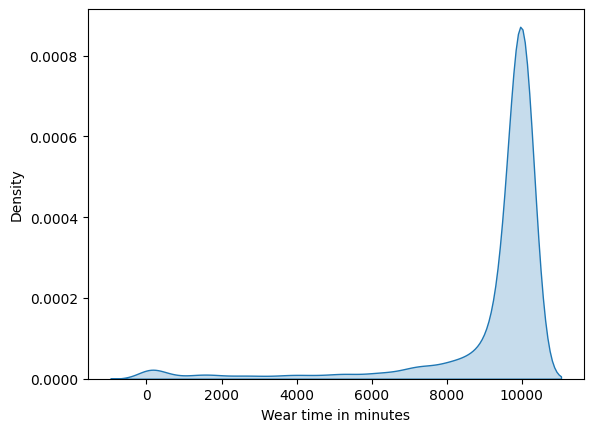

In [25]:
# get weartime duration in minutes (it's in days at default)
main_test["Wear time in minutes"] = main_test.iloc[:,16686]*1440
sns.kdeplot(data = main_test, x= 'Wear time in minutes', fill=True)

# exclude people with insufficient weartime weartime < 8000 minutes
wear_time_test = main_test[main_test["Wear time in minutes"]<8000].index
print("People excluded due to wear time < 8000 minutes:", len(wear_time_test))
brain_test = brain_test.drop(wear_time_test)
main_test = main_test.drop(wear_time_test)

# check wear time and data quality
print(main_test.iloc[:,16650].value_counts())
print(main_test.iloc[:,16651].value_counts())

(0.0, 0.01)

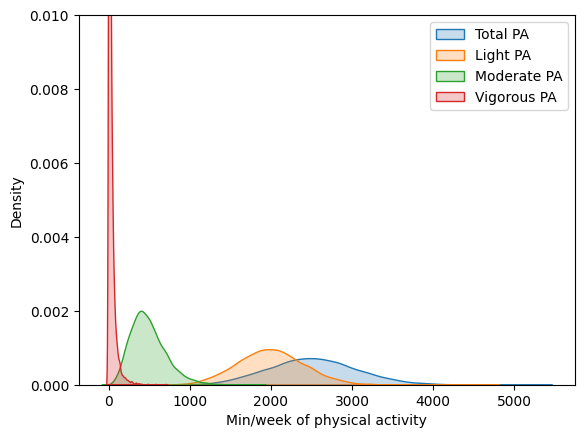

In [26]:
# distributions are cumulative -> substract ditributions from each other
# determine fraction of weartime spent doing light PA (between 30 and 125 milligravites)
light_PA = np.asarray(main_test.iloc[:,16763]-main_test.iloc[:,16748])
# get it in minutes / week
light_PA = light_PA * main_test["Wear time in minutes"]
main_test["Light PA"] = light_PA

# determine fraction of weartime spent doing moderate PA (between 125 and 400 milligravites)
moderate_PA = np.asarray(main_test.iloc[:,16774]-main_test.iloc[:,16763])
moderate_PA = moderate_PA * main_test["Wear time in minutes"]
main_test["Moderate PA"] = moderate_PA

# determine fraction of weartime spent doing vigorous PA (above 400 milligravites)
vigorous_PA = np.asarray(1-main_test.iloc[:,16774])
vigorous_PA = vigorous_PA * main_test["Wear time in minutes"]
main_test["Vigorous PA"] = vigorous_PA

# fraction of weartime for above 30 mg -> total summed light, moderate, and vigorous PA
total_PA = np.asarray(1-main_test.iloc[:,16748])
total_PA = total_PA * main_test["Wear time in minutes"]
main_test["Total PA"] = total_PA

sns.kdeplot(data = main_test, x= 'Total PA', fill=True, label = "Total PA")
sns.kdeplot(data = main_test, x= 'Light PA', fill=True, label = "Light PA")
sns.kdeplot(data = main_test, x= 'Moderate PA', fill=True, label = "Moderate PA")
sns.kdeplot(data = main_test, x= 'Vigorous PA', fill=True, label = "Vigorous PA")
plt.xlabel("Min/week of physical activity")
plt.legend()
plt.ylim(0,0.01)

In [27]:



# recoding imaging site
main_test['uk_biobank_assessment_centre_f54_2_0'] = main_test['uk_biobank_assessment_centre_f54_2_0'].map({'11025': 'Cheadle', '11026': 'Reading','11027': 'Newcastle', '11028': 'Bristol'})
# create mental disorder variable chapter V of ICD-10
mental = main_test[main_test["diagnoses_icd10_f41270_0_0"].str.contains("F")==True].index
main_test.loc[mental,"Mental disorder"] = 1

main_test_all = main_test

# same for full dataset without exclusions
main_test_all_crop = []
main_test_all_crop = pd.DataFrame(main_test_all_crop)

main_test_all_crop["Age"] = main_test_all["Age"]
main_test_all_crop["Gender"] = main_test_all.iloc[:,22]
main_test_all_crop["Total PA"] = main_test_all["Total PA"]
main_test_all_crop["Vigorous PA"] = main_test_all["Vigorous PA"]
main_test_all_crop["Moderate PA"] = main_test_all["Moderate PA"]
main_test_all_crop["Light PA"] = main_test_all["Light PA"]
main_test_all_crop["BMI"] = main_test_all.iloc[:,11580]
main_test_all_crop["ECG max workload"] = main_test_all.iloc[:, 5773]
main_test_all_crop["ECG max heart rate"] = main_test_all.iloc[:, 5775]
main_test_all_crop["SR Walking PA"] = main_test_all.iloc[:,9989]
main_test_all_crop["SR Moderate PA"] = main_test_all.iloc[:,9990]
main_test_all_crop["SR Vigorous PA"] = main_test_all.iloc[:,9991]
main_test_all_crop["Fluid intelligence"] = main_test_all.iloc[:,9052]
main_test_all_crop["Hand grip L"] = main_test_all.iloc[:,64]
main_test_all_crop["Hand grip R"] = main_test_all.iloc[:,68]
main_test_all_crop["Imaging site"] = main_test_all['uk_biobank_assessment_centre_f54_2_0']
main_test_all_crop["Smoking"] = main_test_all.iloc[:,650]
main_test_all_crop["Townsend deprivation"] = main_test_all.iloc[:,456]
main_test_all_crop["Mental disorder"] = main_test_all["Mental disorder"]
main_test_all_crop["Heart rate"] = main_test_all.iloc[:,10079]
main_test_all_crop["Job PA"] = main_test_all.iloc[:,507]
main_test_all_crop["D Blood pressure"] = main_test_all.iloc[:,1551]
main_test_all_crop["S Blood pressure"] = main_test_all.iloc[:,1559]
main_test_all_crop["Walking speed"] = main_test_all.iloc[:,542]
main_test_all_crop["BA ASEG Delta Corr"] = main_test_all["BA ASEG Delta Corr"]
main_test_all_crop["BA A2009 Delta Corr"] = main_test_all["BA A2009 Delta Corr"]
main_test_all_crop["BA Desikan Delta Corr"] = main_test_all["BA Desikan Delta Corr"]
main_test_all_crop["BA Delta Corr"] = main_test_all["BA Delta Corr"]

main_test = main_test_all_crop

main_test.head()

,Age,Gender,Total PA,Vigorous PA,Moderate PA,Light PA,BMI,ECG max workload,ECG max heart rate,SR Walking PA,SR Moderate PA,SR Vigorous PA,Fluid intelligence,Hand grip L,Hand grip R,Imaging site,Smoking,Townsend deprivation,Mental disorder,Heart rate,Job PA,D Blood pressure,S Blood pressure,Walking speed,BA ASEG Delta Corr,BA A2009 Delta Corr,BA Desikan Delta Corr,BA Delta Corr
24945,65.0,Male,1474.0416,18.0864,198.9504,1257.0048,28.9,NaN,NaN,412.5,80.0,0.0,7.0,49.0,40.0,Cheadle,No,-2.27794,NaN,NaN,Never/rarely,81.0,121.0,Brisk pace,7.130098,11.919675,47.819977,2.965450
34655,61.0,Male,2388.9600,50.4000,463.6800,1874.8800,23.9,NaN,NaN,198.0,400.0,240.0,6.0,29.0,29.0,Cheadle,No,-3.79876,NaN,55.0,Never/rarely,88.0,156.0,Brisk pace,-2.874114,0.936038,9.301980,-0.725580
21099,55.0,Female,2246.7456,8.5104,272.3328,1965.9024,44.5,NaN,NaN,1386.0,240.0,0.0,6.0,26.0,26.0,Cheadle,No,-1.96244,NaN,NaN,Never/rarely,115.0,185.0,Steady average pace,-1.218352,-1.992390,-25.705642,0.870366
23431,67.0,Male,1854.7200,40.3200,413.2800,1401.1200,25.1,NaN,NaN,396.0,320.0,960.0,6.0,36.0,19.0,Cheadle,No,-1.88219,NaN,54.0,NaN,85.0,148.0,Brisk pace,5.987548,2.278009,-6.137504,4.281932
24485,63.0,Male,2093.7024,9.3888,281.6640,1802.6496,41.0,120.0,112.0,264.0,300.0,160.0,8.0,56.0,46.0,Cheadle,No,-4.54202,NaN,60.0,Never/rarely,83.0,151.0,Brisk pace,9.414016,7.824680,27.733906,-0.471723


In [28]:
main_test['Imaging site'] = main_test['Imaging site'].map({'Cheadle': 1, 'Reading': 2,'Newcastle': 3, 'Bristol': 4})
main_test["Smoking"] = main_test["Smoking"].map({"No":0, "Only occasionally":1, "Yes, on most or all days":2})
main_test["Gender"] = main_test["Gender"].map({"Female":0, "Male":1})
main_test["Job PA"] = main_test["Job PA"].map({"Never/rarely":0, "Sometimes":1, "Usually":2,"Always":3})
main_test["Walking speed"] = main_test["Walking speed"].map({"Slow pace":0, "Steady average pace":1, "Brisk pace":2})
main_test["Gender"] = main_test["Gender"].astype("int")
main_test["MVPA"] = main_test["Moderate PA"] + main_test["Vigorous PA"]*2

del main_test["BA Desikan Delta Corr"]
del main_test["BA Delta Corr"]
del main_test["BA ASEG Delta Corr"]
del main_test["Mental disorder"]


main_test = main_test.rename(columns={"BA A2009 Delta Corr": "BA", "Total PA":"TPA", "Light PA":"LPA", "Moderate PA": "MPA","Vigorous PA":"VPA", "ECG max workload":"ECGW", 
    "ECG max heart rate":"ECGH","Townsend deprivation":"SES", "SR Walking PA":"SRLPA", "SR Moderate PA":"SRMPA", "SR Vigorous PA":"SRVPA",
     "Heart rate":"HR","Hand grip R":"HGR", "Imaging site":"IS", "Fluid intelligence":"FI", "S Blood pressure":"SBP", "D Blood pressure":"DBP"})

main_test = pd.DataFrame(main_test)

Text(0.5, 1.0, 'Correlations All')

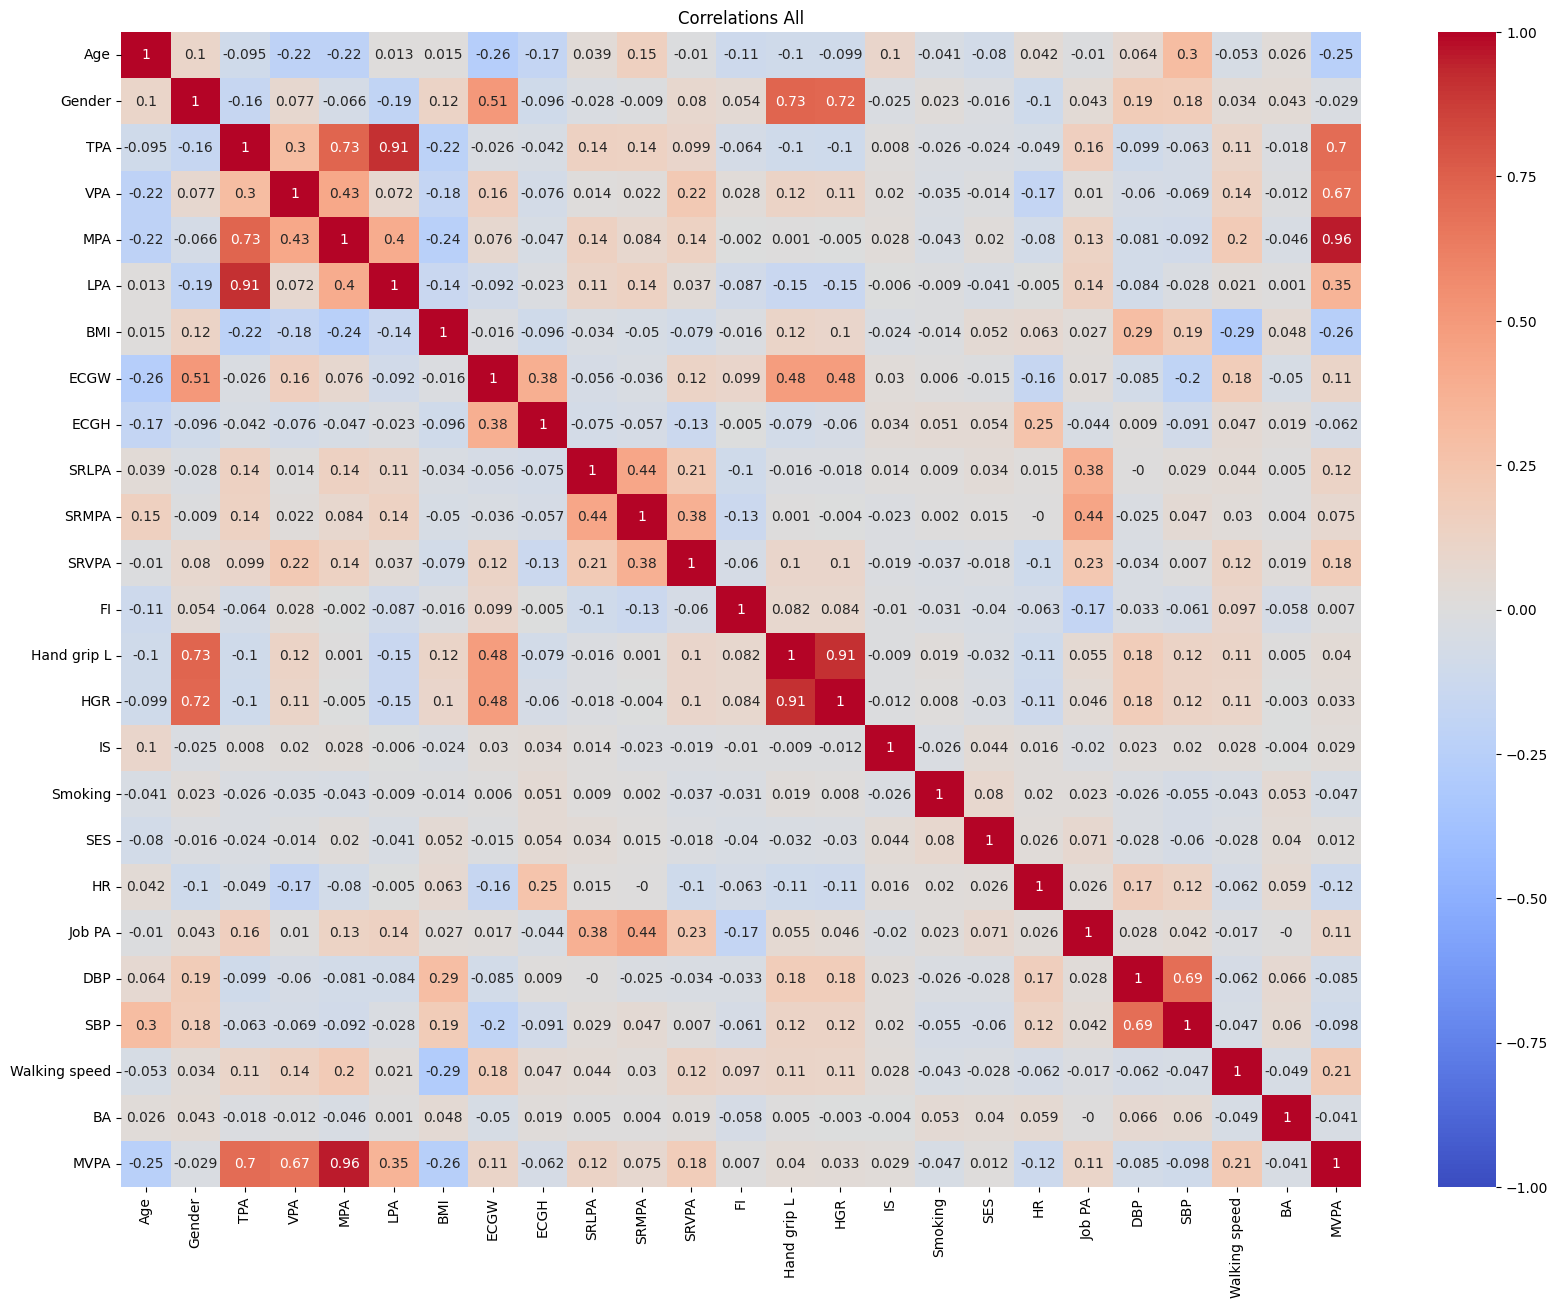

In [29]:
corr = main_test.corr()
corr = round(corr,3)
fig, ax = plt.subplots(figsize=(20,15)) 
sns.heatmap(corr, annot=True, cmap = "coolwarm", vmin=-1, vmax=1)
plt.title("Correlations All")

In [30]:
pa_model = ols('BA ~ LPA + MPA + VPA + Gender + Age + IS + Gender:Age + Gender:IS', missing='drop', data = main_test).fit()
print(pa_model.summary())

                            OLS Regression Results                            
Dep. Variable:                     BA   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     6.146
Date:                Tue, 13 Dec 2022   Prob (F-statistic):           6.23e-08
Time:                        15:49:57   Log-Likelihood:                -28550.
No. Observations:                8386   AIC:                         5.712e+04
Df Residuals:                    8377   BIC:                         5.718e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3817      1.018      0.375      0.7

In [31]:
sr_pa_model = ols('BA ~ SRLPA + SRMPA + SRVPA +LPA + MPA + VPA+ Gender + Age + IS + Gender:Age + Gender:IS', missing='drop', data = main_test).fit()
print(sr_pa_model.summary())

                            OLS Regression Results                            
Dep. Variable:                     BA   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     4.404
Date:                Tue, 13 Dec 2022   Prob (F-statistic):           1.26e-06
Time:                        15:49:57   Log-Likelihood:                -24392.
No. Observations:                7171   AIC:                         4.881e+04
Df Residuals:                    7159   BIC:                         4.889e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2065      1.113      1.084      0.2

In [32]:
model_comparison = anova_lm(pa_model, sr_pa_model)
print(model_comparison)

   df_resid            ssr  df_diff       ss_diff         F    Pr(>F)
0    8377.0  444772.599189      0.0           NaN       NaN       NaN
1    7159.0  378095.925463   1218.0  66676.673726  1.036518  0.202698
